In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import torch.nn.functional as F
import os, glob
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from packages.visual_utils import *
from packages.data_utils import *
#from packages.training import Pangolin, PangolinEXP
from lightning.pytorch import Trainer
from packages.training_lighting import PangolinLitModule  # adjust import as needed


L = 32
# convolution window size in residual units
W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
# atrous rate in residual units
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [2]:
!aws s3 cp s3://research.luffingfuturellc/Pangolin/20Samples_training_data_sequece_exp_model.pt ./Model/

download: s3://research.luffingfuturellc/Pangolin/20Samples_training_data_sequece_exp_model.pt to Model/20Samples_training_data_sequece_exp_model.pt


In [3]:
#cuda.close()
list_model = glob.glob("Model/*.pt")
print (list_model)

['Model/final.5.7.3.pt', 'Model/20Samples_training_data_sequece_exp_model.pt']


In [4]:
#Load the Pretrained Model
#seq_model = PangolinEXP(L=L, W=W, AR=AR)
model = Pangolin(L=L, W=W, AR=AR)
model_path = 'Model/20Samples_training_data_sequece_exp_model.pt'
model_path = 'Model/final.5.7.3.pt'
state_dict = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(state_dict)

Model device: cuda:0
Loading Data:  269


In [49]:
# Load model from .ckpt
model = PangolinLitModule.load_from_checkpoint(
    checkpoint_path="final_2027sTS_exp_model_epochepoch=99.ckpt",
    L=32,
    W=W,
    AR=AR
)

In [50]:
# Move model to GPU################
model.to(device)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(model.parameters()).device)

# Load preprocessed training data
data = torch.load("2027sTS_training_data_sequece_exp.pt", weights_only=True)
#data = torch.load("gene_merged_training_data.pt", weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:
print("Loading Data: ", len(training_input))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

#pred = seq_model(training_input[0:50, :4, :].to(device)).detach().cpu()[:, 0:3, :]
with torch.no_grad():
    pred = model(training_input.to(device)).to(device).detach().cpu()

Model device: cuda:0
Loading Data:  5


1


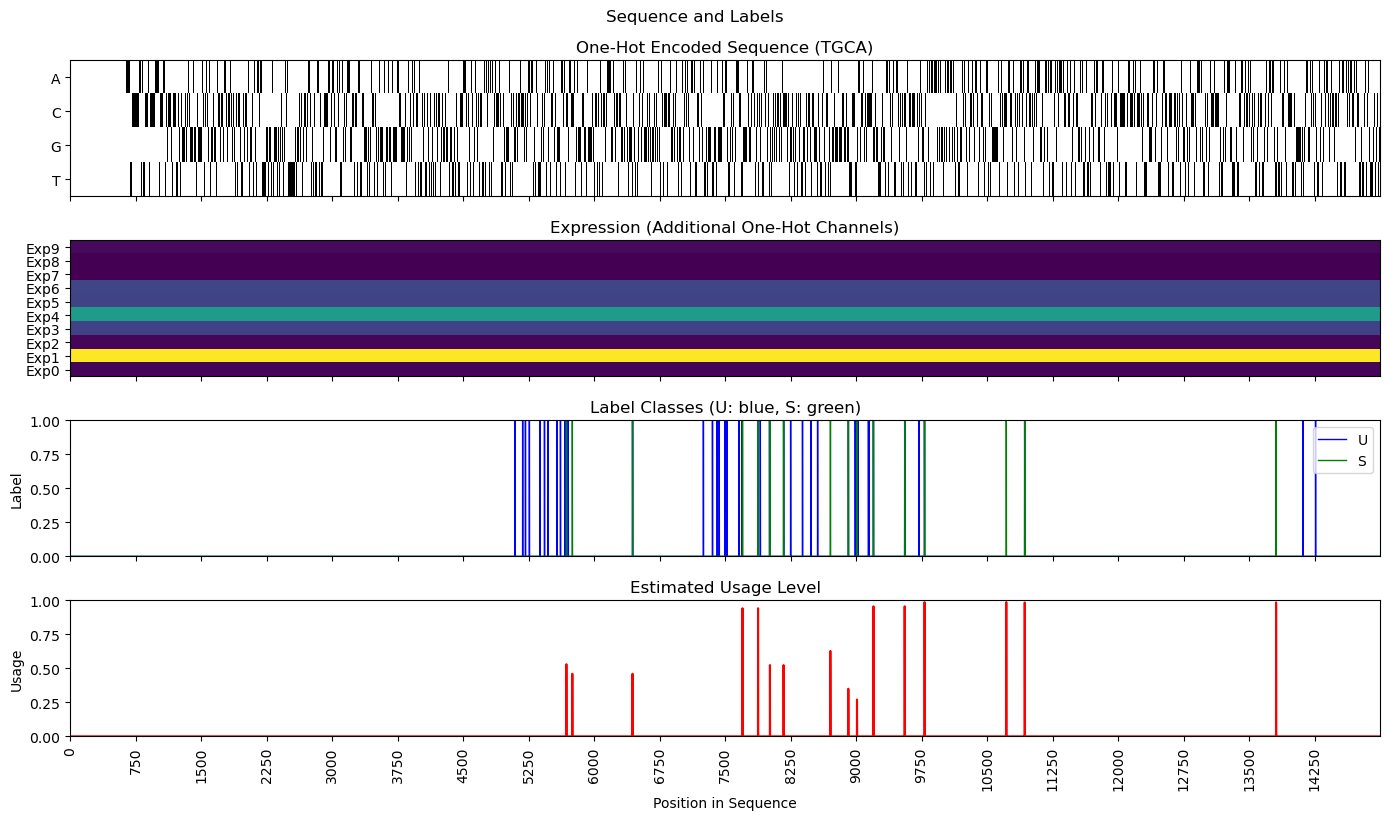

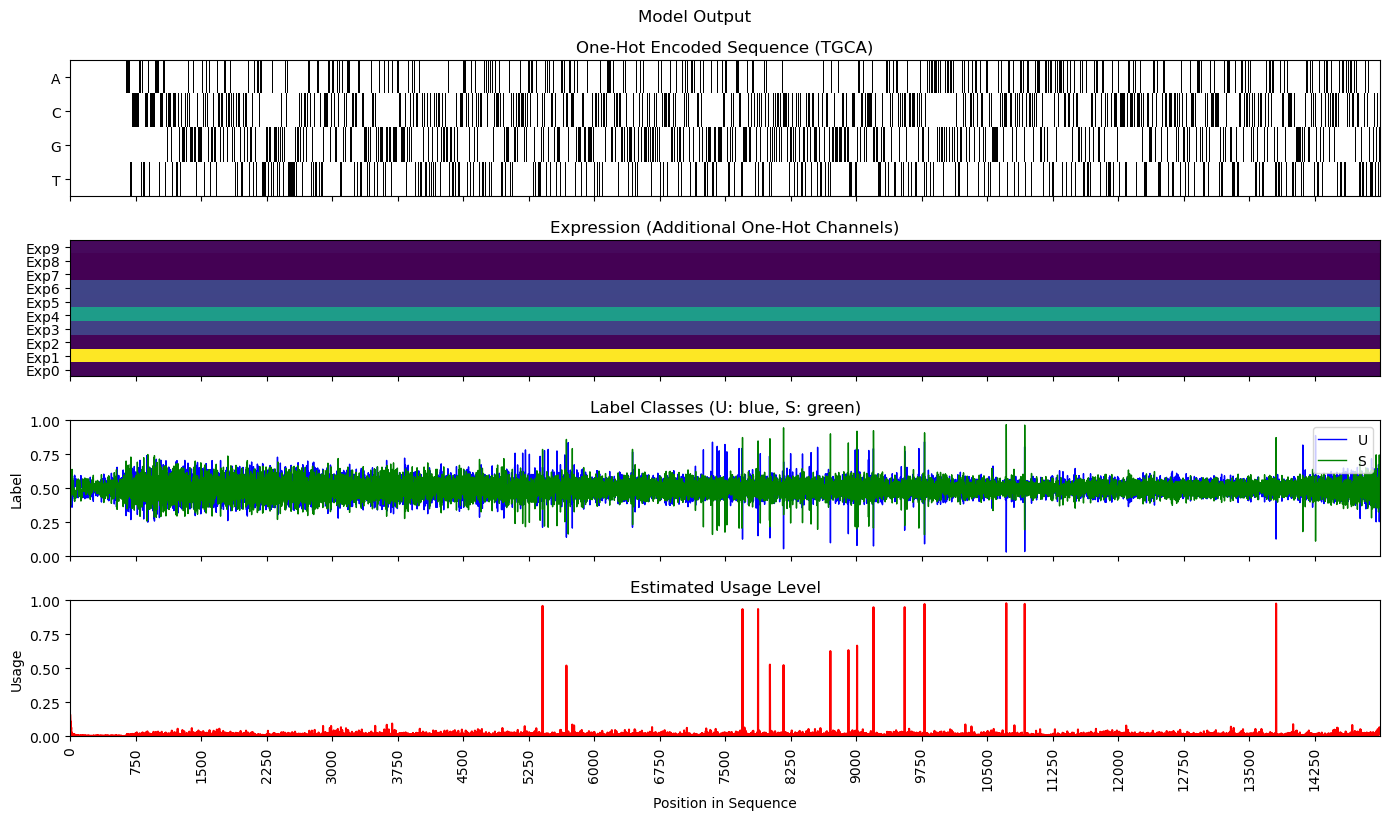

In [51]:
cor_start = 0
cor_end = 15000

for i in range(1, 5, 1):
    print (i)
    pad_zeros = torch.zeros_like(pred[i])
    plot_one_hot_and_labels_zoom(training_input[i], training_label[i], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")
    plot_one_hot_and_labels_zoom(training_input[i], pred[i],
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")
    break

In [20]:
#plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")

0


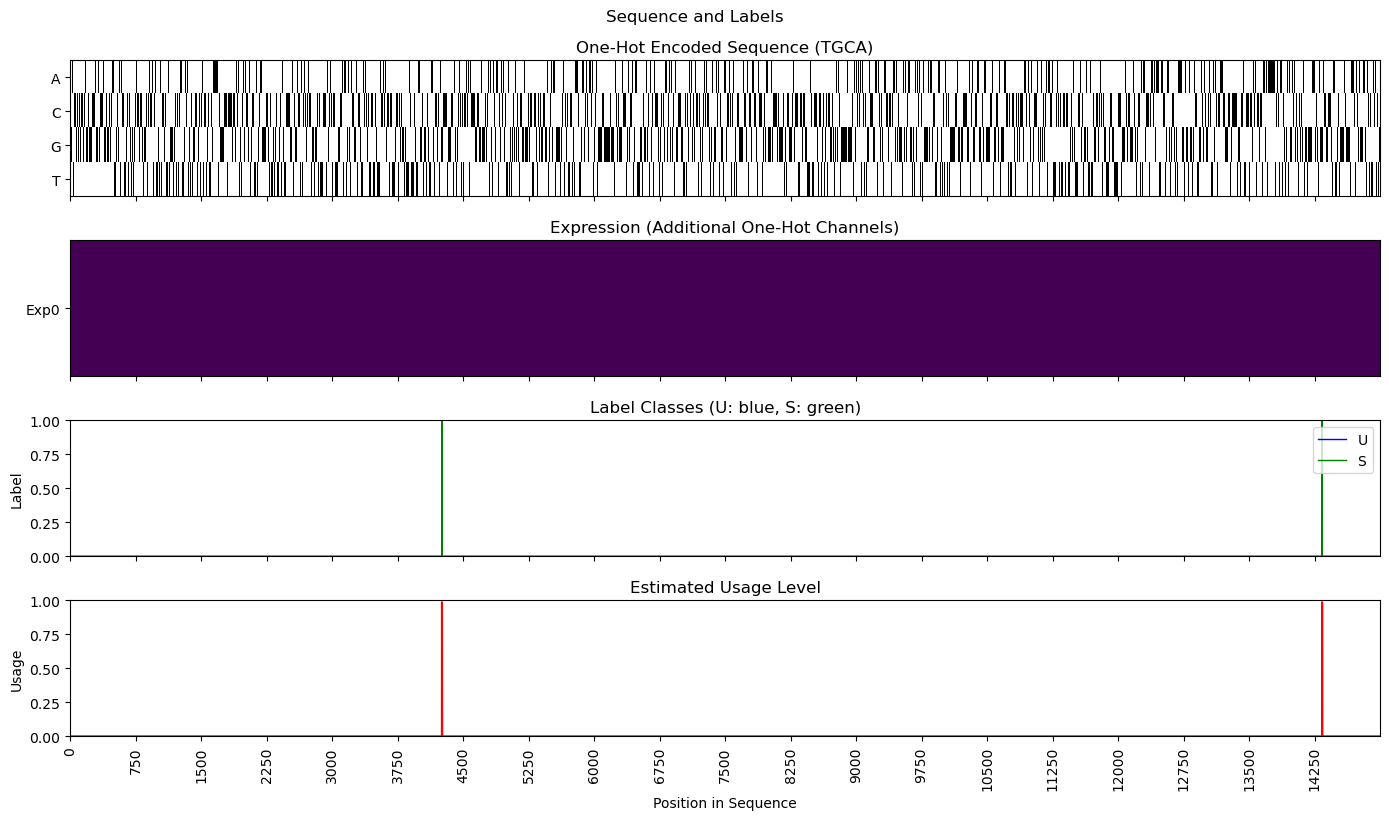

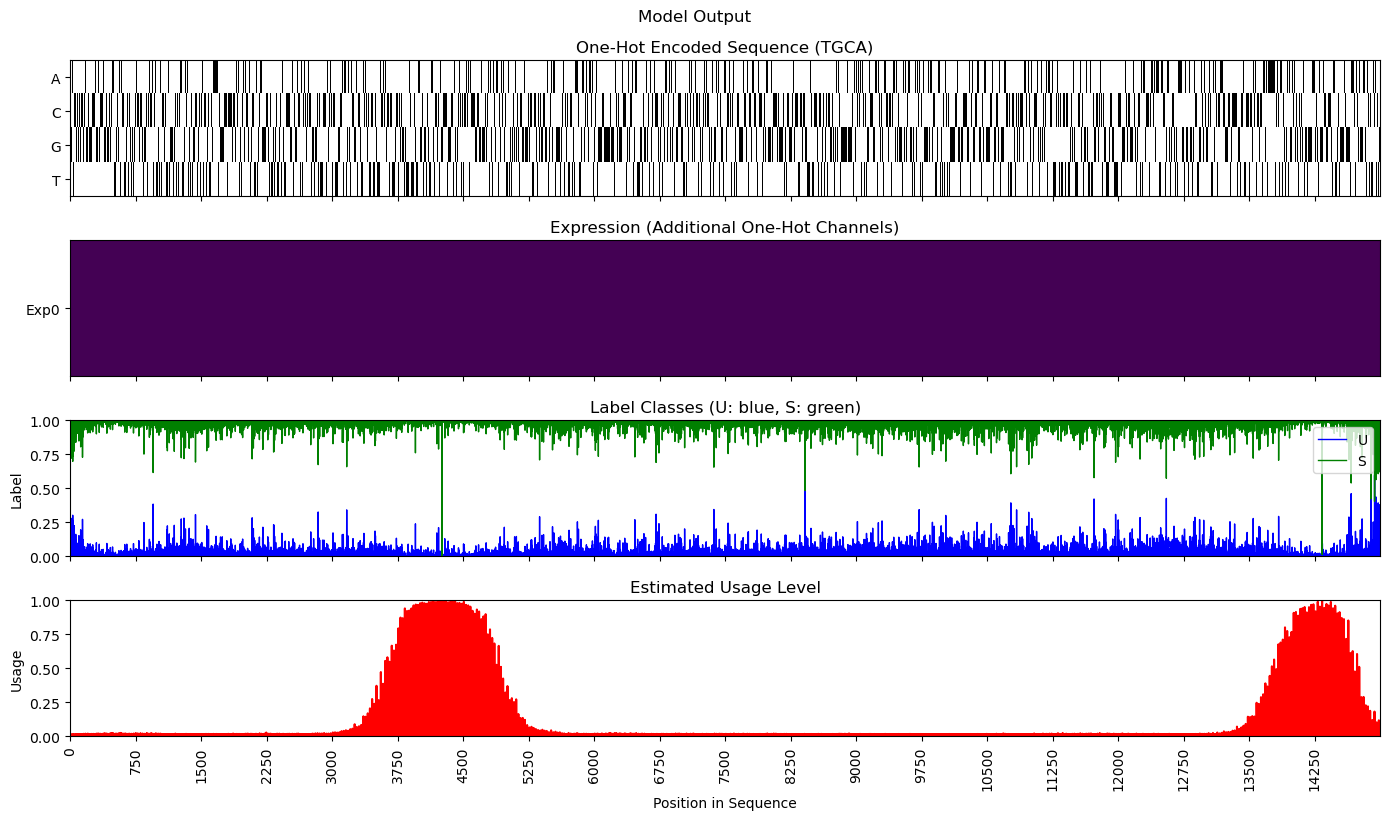

In [27]:
## echo 200
order_select = 0
cor_start = 0
cor_end = 15000

for i in range(10):
    print (i)
    pad_zeros = torch.zeros_like(pred[i])
    plot_one_hot_and_labels_zoom(training_input[i], training_label[i], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")
    test_predict_coordinates = torch.cat([pad_zeros, pred[i], pad_zeros], dim=1)
    plot_one_hot_and_labels_zoom(training_input[i], pred[i],
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")
    break

0


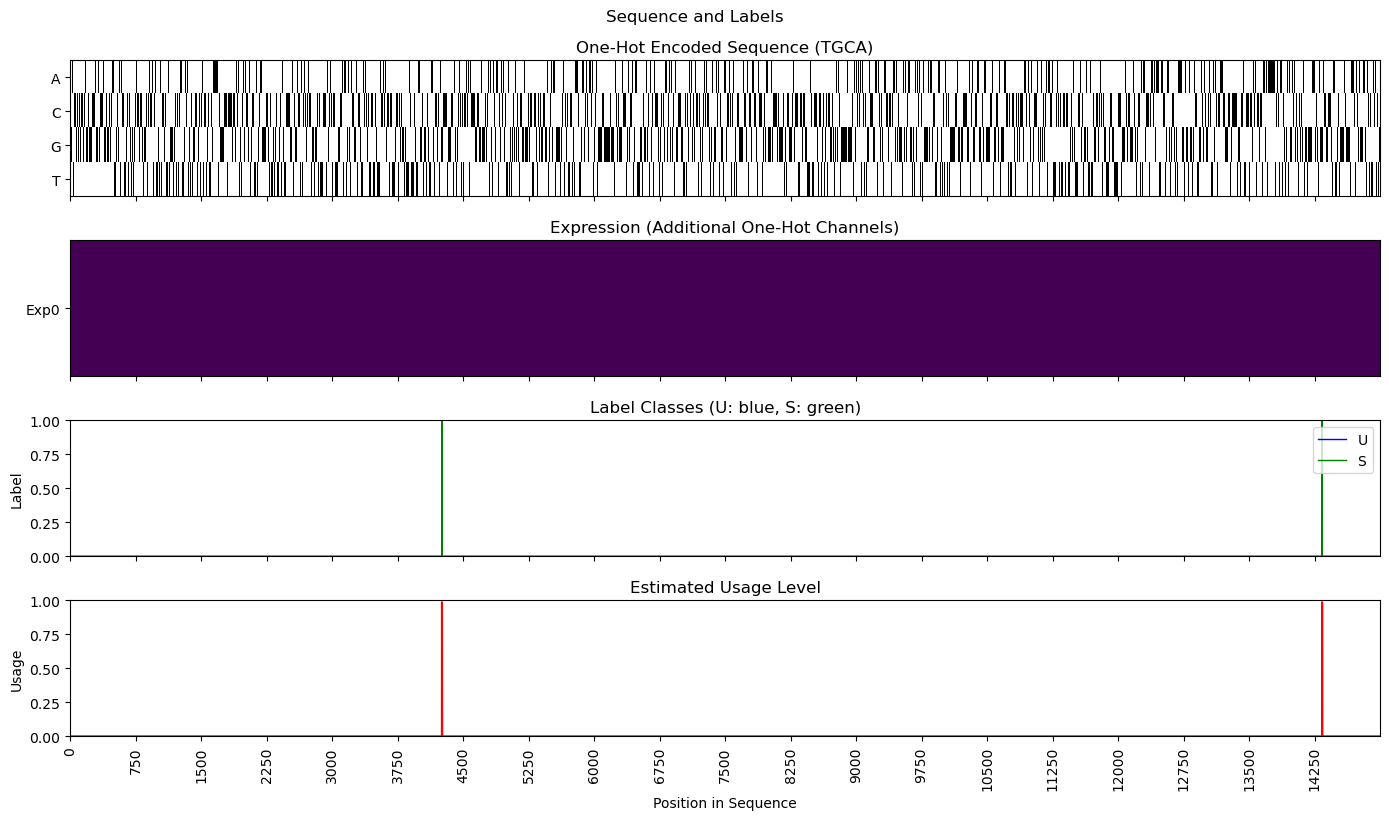

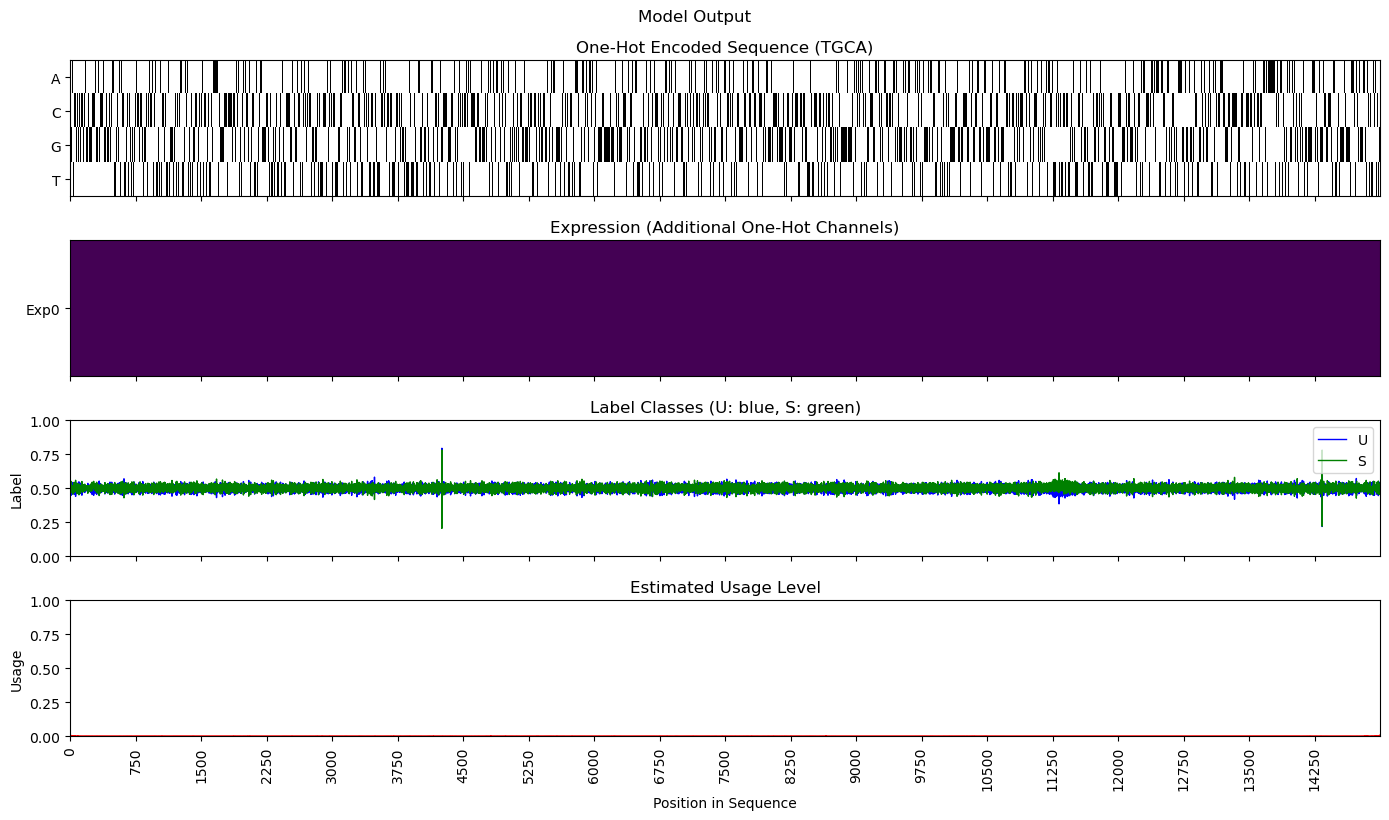

In [5]:
#plt.plot(pred[2])
#plt.plot(test_predict_coordinates
order_select = 0
cor_start = 0
cor_end = 15000

for i in range(10):
    print (i)
    pad_zeros = torch.zeros_like(pred[i])
    plot_one_hot_and_labels_zoom(training_input[i], training_label[i], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")
    test_predict_coordinates = torch.cat([pad_zeros, pred[i], pad_zeros], dim=1)
    plot_one_hot_and_labels_zoom(training_input[i], pred[i],
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")
    break

Number of N: 0 out of 15000


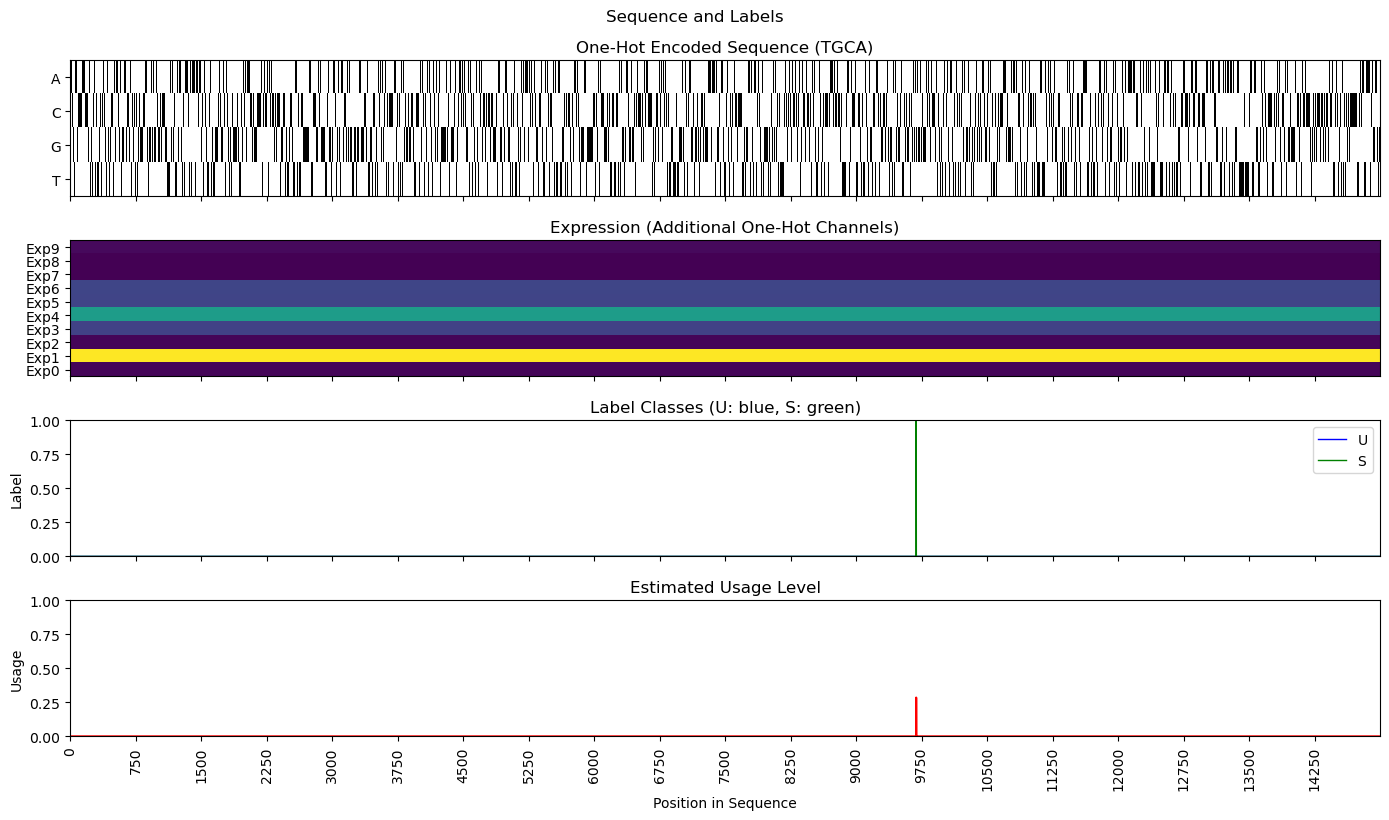

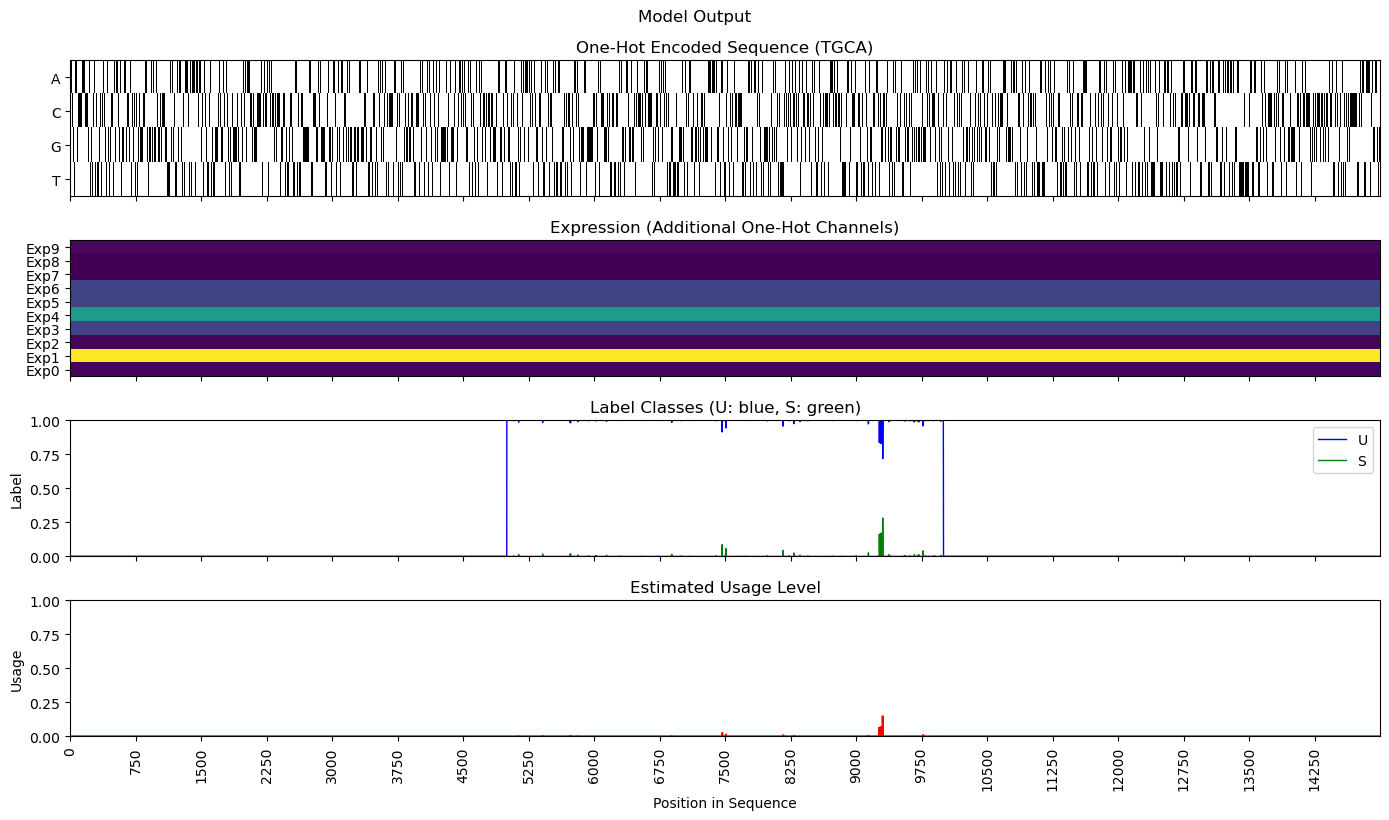

In [46]:
order_select = 7

test_data = training_input[order_select:order_select+1, :4, :].to(device)
#test_data = training_input[order_select:order_select+1, :14, :].to(device)

print("Number of N:", decode_one_hot(training_input[order_select][0:4, :]).count('N'), "out of 15000")
pred = seq_model(test_data).detach().cpu()[0, 0:3,:]

cor_start = 0
cor_end = 15000

plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")


test_predict_coordinates = torch.cat([torch.zeros_like(pred), pred, torch.zeros_like(pred)], dim=1)
plot_one_hot_and_labels_zoom(training_input[order_select], test_predict_coordinates,
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")

Number of N: 0 out of 15000


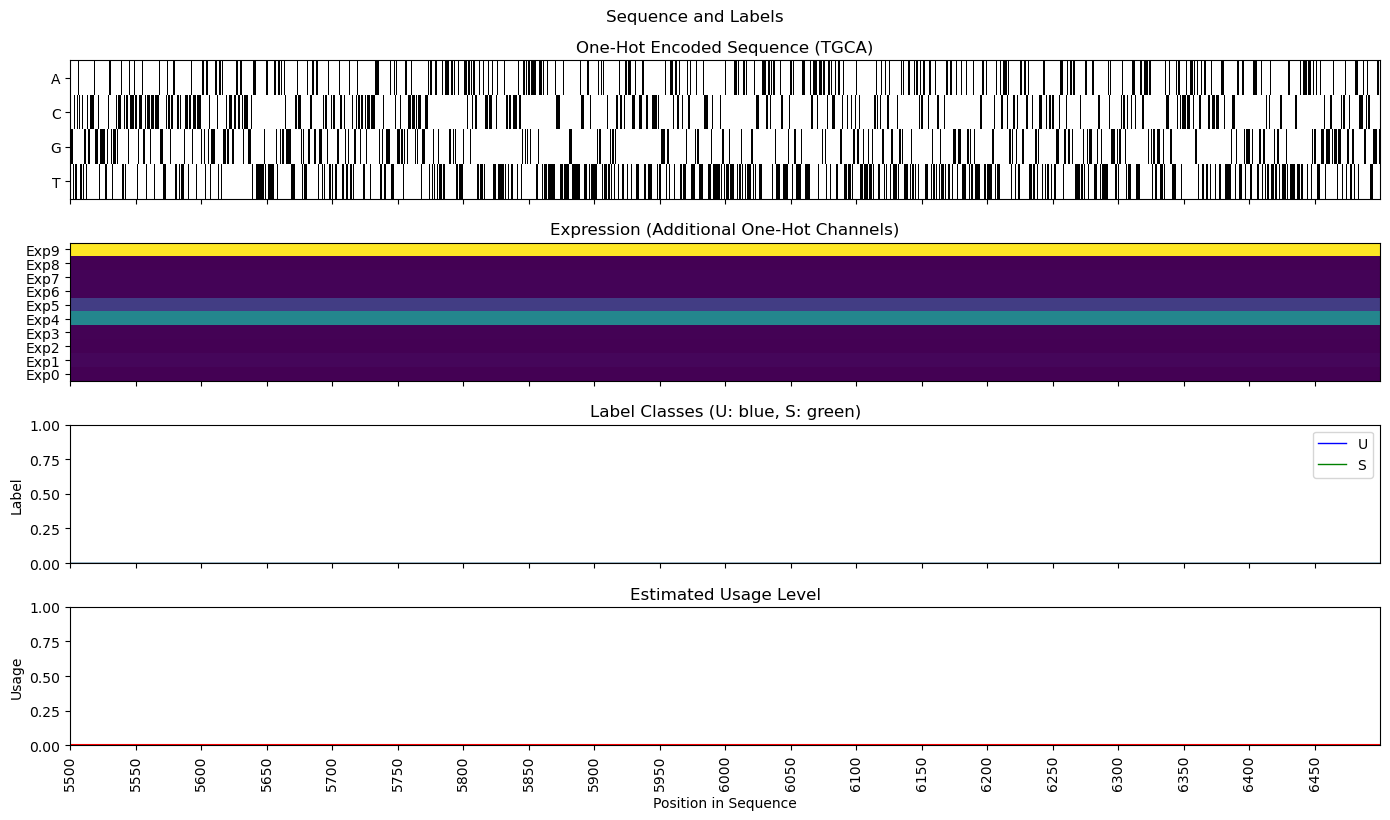

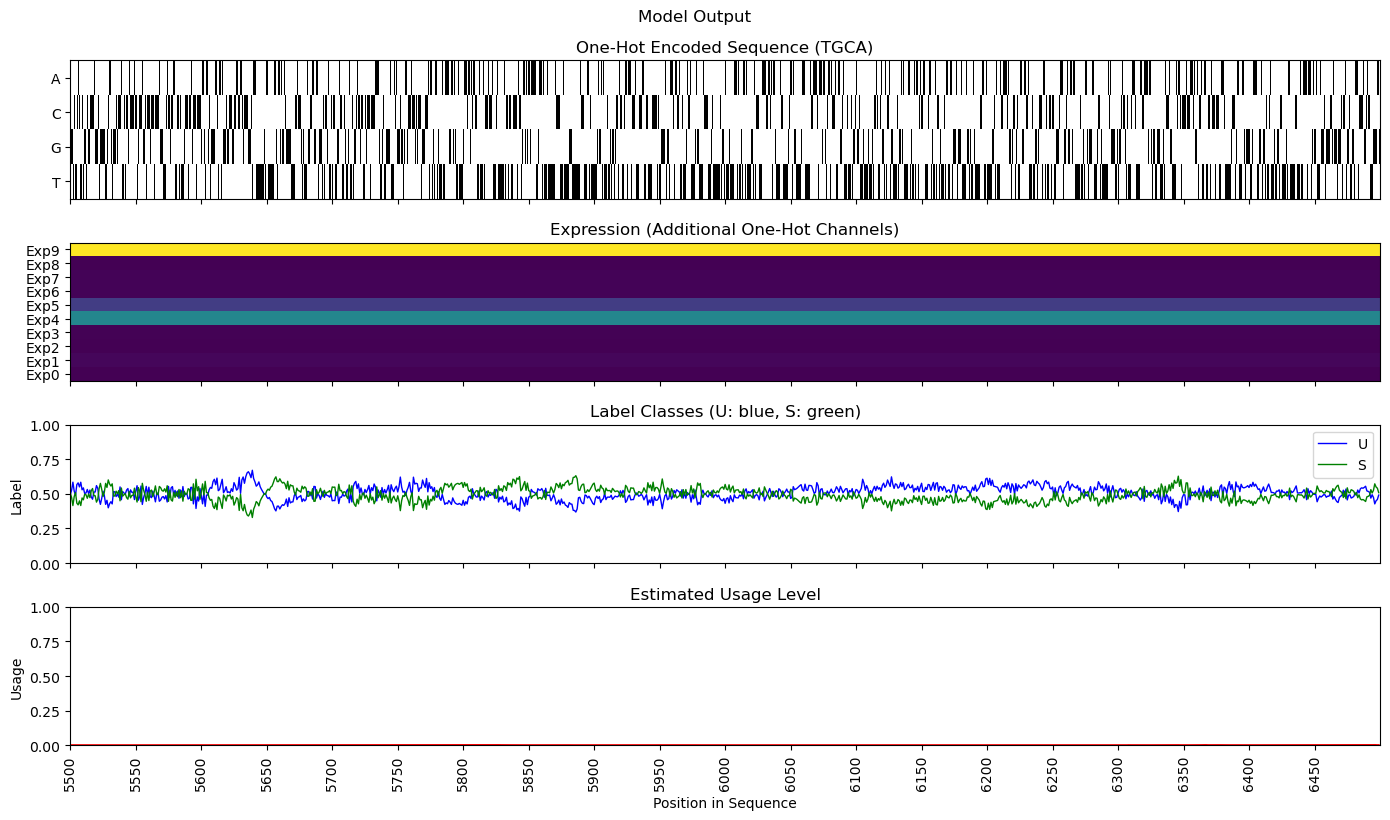

In [66]:
order_select = 0
test_data = training_input[order_select:order_select+1, :14, :].to(device)
print("Number of N:", decode_one_hot(training_input[order_select][0:4, :]).count('N'), "out of 15000")
pred = seq_model(test_data)

cor_start = 5500
cor_end = 6500

plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")


plot_one_hot_and_labels_zoom(training_input[order_select], pred.detach().cpu()[0, 0:3,:], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")

In [ ]:
#Load the Pretrained Model
seq_model = Pangolin(L=L, W=W, AR=AR)
state_dict = torch.load("Model/102_samples_sequence_exp_model.pt", map_location=device, weights_only=True)
seq_model.load_state_dict(state_dict)

# Move model to GPU################
seq_model.to(device)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(seq_model.parameters()).device)

# Load preprocessed training data
data = torch.load("102_training_data_sequece_exp.pt", weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
test_data = training_input[0:100].to(device)

#og_output = og_model(input_data)

In [11]:
test_data[0].shape

torch.Size([4, 15000])